# 학습 목표
1. 유전자 발현 데이터를 이용하여 바이오마커 후보를 탐색하는 과정을 이해한다.
2. 유방암(1) vs 정상(0) 레이블을 가진 데이터를 무작위로 훈련/테스트 세트로 나누고,
   랜덤 포레스트 분류 모델을 학습한다.
3. 모델이 중요하게 여기는 유전자(특징)를 찾아, 바이오마커 후보로 삼는 방법을 익힌다.
4. 주요 바이오마커만 이용해서 모델을 재학습하고 평가한다.



# 1. 데이터 설명
- Breast cancer.xlsx : 78행 × N열
   - 78명의 샘플(행), N개의 유전자 발현값(열)
   - 첫 행부터 유전자 명이 주어지지 않았으므로, "gene1", "gene2" ... 로 직접 컬럼명 부여
- Breast cancer labels.xlsx : 1행 × 78열
   - 78개의 값(0 또는 1)
   - 1 : 유방암 환자, 0 : 정상인

# 2. 라이브러리 임포트

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 3. 데이터 불러오기

In [ ]:
# header=None => 엑셀에 컬럼명이 없는 경우
gene_df = pd.read_excel("Breast cancer.xlsx", header=None)

# 열 개수만큼 gene1, gene2 ... 로 이름 부여
gene_df.columns = [f"gene{i+1}" for i in range(gene_df.shape[1])]

# 레이블 불러오기 (1행 x 78열)
label_df = pd.read_excel("Breast cancer labels.xlsx", header=None)

# label_df는 (1, 78) 형태이므로, 1차원 (78,)으로 변환
y = label_df.values.flatten()

# X는 (78, N) 형태의 유전자 발현 행렬
X = gene_df.values

print("데이터셋 크기:", X.shape, "레이블 길이:", len(y))
print("X 예시 (앞부분):")
print(gene_df.head())
print("y 예시 (처음 10개):", y[:10])

데이터셋 크기: (78, 12172) 레이블 길이: 78
X 예시 (앞부분):
   gene1  gene2  gene3  gene4  gene5  gene6  gene7  gene8  gene9  gene10  ...  \
0   0.77  -1.30  -0.55      0      0   1.06   0.01      0      0       0  ...   
1   0.70  -1.44  -0.42      0      0   1.00  -0.11      0      0       0  ...   
2   0.49  -1.40  -0.29      0      0   1.09   0.06      0      0       0  ...   
3   0.75  -1.43  -0.45      0      0   0.99  -0.19      0      0       0  ...   
4   0.70  -1.36  -0.53      0      0   1.15  -0.13      0      0       0  ...   

   gene12163  gene12164  gene12165  gene12166  gene12167  gene12168  \
0      -1.06          0          0          0          0       1.99   
1      -0.68          0          0          0          0       2.11   
2      -0.77          0          0          0          0       2.07   
3      -0.59          0          0          0          0       2.07   
4      -0.78          0          0          0          0       2.16   

   gene12169  gene12170  gene12171  gene12

# 4. 데이터 전처리

In [ ]:
# 데이터 전처리(스케일링)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 5. 랜덤 포레스트 분류 모델 학습
- 바이오마커 발굴에는 "해석 가능한 모델"이 자주 사용됨
- 예: Random Forest, Lasso(회귀), XGBoost(Feature Importance), SHAP 등

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# 6. 모델 성능 평가

In [ ]:
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 0.8750

Confusion Matrix:
[[7 1]
 [1 7]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8750    0.8750    0.8750         8
           1     0.8750    0.8750    0.8750         8

    accuracy                         0.8750        16
   macro avg     0.8750    0.8750    0.8750        16
weighted avg     0.8750    0.8750    0.8750        16



# 7. Feature Importance (바이오마커 후보 탐색)

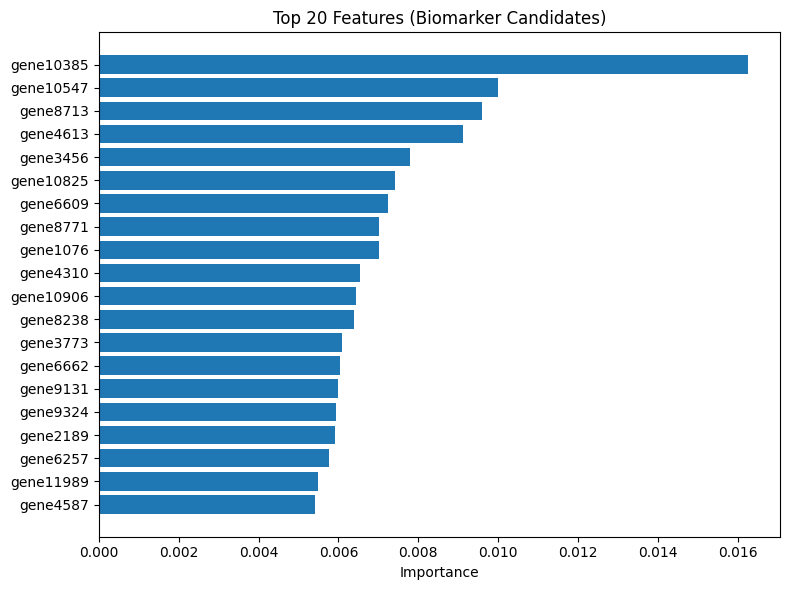

가장 중요한 상위 5개 특징 (바이오마커 후보):
1) gene10385 - 중요도: 0.0162
2) gene10547 - 중요도: 0.0100
3) gene8713 - 중요도: 0.0096
4) gene4613 - 중요도: 0.0091
5) gene3456 - 중요도: 0.0078


In [ ]:
# 1) 랜덤 포레스트 중요도 계산 (동일)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # 중요도 높은 순서로 정렬

# 2) 상위 N개만 추려서 데이터프레임으로 구성
top_n = 20  # 원하는 만큼 조절
top_indices = indices[:top_n]
top_features = gene_df.columns[top_indices]
top_importances = importances[top_indices]

# 3) 가로 막대 그래프로 시각화
plt.figure(figsize=(8, 6))
plt.barh(top_features, top_importances, align="center")
plt.xlabel("Importance")
plt.title(f"Top {top_n} Features (Biomarker Candidates)")
plt.gca().invert_yaxis()  # 중요도 높은 항목이 위로 오도록
plt.tight_layout()
plt.show()

# 상위 일부만 출력
top_n = 5
print(f"가장 중요한 상위 {top_n}개 특징 (바이오마커 후보):")
for i in range(top_n):
    idx = indices[i]
    print(f"{i+1}) {gene_df.columns[idx]} - 중요도: {importances[idx]:.4f}")

# 8. 검증
상위 N개 유전자만 골라 다시 학습 및 평가

In [ ]:
top_n = 3
top_indices = indices[:top_n]

X_train_top = X_train[:, top_indices]
X_test_top  = X_test[:, top_indices]

rf_top = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top.fit(X_train_top, y_train)
y_pred_top = rf_top.predict(X_test_top)

acc_top = accuracy_score(y_test, y_pred_top)
print(f"[상위 {top_n}개 유전자만 사용] Accuracy:", acc_top)

print("\n[전체 유전자 vs 상위 20개 특징] 성능 비교")
print(" - 전체 유전자 사용  :", acc)
print(f" - 상위 {top_n}개 사용:", acc_top)

[상위 3개 유전자만 사용] Accuracy: 0.875

[전체 유전자 vs 상위 20개 특징] 성능 비교
 - 전체 유전자 사용  : 0.875
 - 상위 3개 사용: 0.875
